<a href="https://colab.research.google.com/github/vifirsanova/NLP-Discussion-Group/blob/master/NLP_tutorials/BERT_binary_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Адаптация [туториала для классификации спама](https://github.com/prateekjoshi565/Fine-Tuning-BERT).

Адаптировала [Виктория Фирсанова](https://github.com/vifirsanova):
- добавлены комментарии и иллюстрации;
- добавлен материал про данные для русского языка;
- присутствуют изменения.

# Импорт библиотек, подготовка

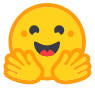

In [1]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd

# для деления выборки на обучающую и проверочную
# работа с несбалансированными классами
# в конце работы оценим качество классификатора
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# модель, токенизатор, алгоритм оптимизации
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

# библиотека для машинного обучения
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Выберите аппаратный ускоритель GPU. 

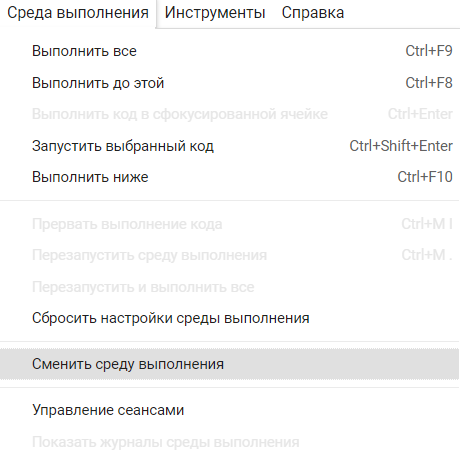

In [3]:
# заранее задайте аппаратный ускоритель в качестве устройства
# это понадобится нам позже
device = torch.device("cuda")

# [Датасет](https://www.kaggle.com/blackmoon/russian-language-toxic-comments?select=labeled.csv)

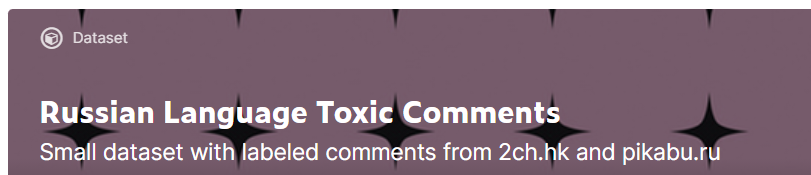

In [4]:
# после скачивания и загрузки распаковать
!unzip labeled.csv.zip

unzip:  cannot find or open labeled.csv.zip, labeled.csv.zip.zip or labeled.csv.zip.ZIP.


In [5]:
df = pd.read_csv("labeled.csv")
df["toxic"] = df.toxic.astype(int)
df.sample(10)

,comment,toxic
10513,"Ну, я бы так не сказал, даже если с Д2 сравнив...",0
6361,Святая толстота! Их мимокрокодил-музыкант почт...,1
6242,"Хуле, жилеты всегда были салатом с креветками....",0
11722,"Если это так, почему водители фур сами ими не ...",0
4761,А ещё там регулярно проводят концерты мировые ...,0
7635,"Не из какого города зашёл, а в каком городе ко...",0
4776,"У меня тоже доча в отцовскую породу, никакого ...",0
6976,"Вот вот, мы тут подумали - картинка не сильно ...",0
1634,"Раз тут таких много, кому нечего ответить, мож...",1
10794,"Возможно это один конкретный случай, а в основ...",0


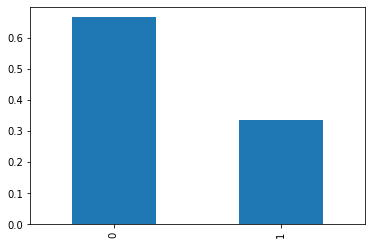

In [6]:
# распределение классов
df['toxic'].value_counts(normalize = True).plot.bar();

# Обучающая, проверочная и тестовая выборки с текстами и метками

In [7]:
# train - обучающая выборка (70% данных)
# temp - временная выборка для создания проверочной и тестовой (30% данных)
train_text, temp_text, train_labels, temp_labels = train_test_split(df['comment'], df['toxic'], 
                                                                    random_state=1999, 
                                                                    test_size=0.3, 
                                                                    stratify=df['toxic'])

# временная выборка делится пополам, получаем:
# val - проверочную выборку, 
# test - тестовую выборку
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=1999, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# [Выбираем модель](https://huggingface.co/models)

In [8]:
# https://huggingface.co/DeepPavlov/rubert-base-cased
model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')
tokenizer = BertTokenizerFast.from_pretrained('DeepPavlov/rubert-base-cased')

# Токенизация

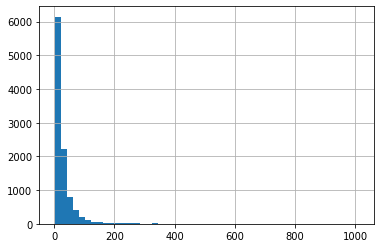

In [9]:
# длина текстов
pd.Series([len(i.split()) for i in train_text]).hist(bins = 50)

In [10]:
sent_a = "Короткое предложение."
sent_b = "Еще одно короткое предложение. И еще одно."

encoded_sent_a = tokenizer(sent_a)["input_ids"]
encoded_sent_b = tokenizer(sent_b)["input_ids"]

print("Предложение А:")
print(encoded_sent_a)
print("Предложение B:")
print(encoded_sent_b)
print()

padded_sequences = tokenizer([sent_a, sent_b], padding=True)
print("Предложение А c примененным паддингом:")
print(padded_sequences["input_ids"][0])
print("Предложение B c примененным паддингом:")
print(padded_sequences["input_ids"][1])
print()

print("Предложение А c маской:")
print(padded_sequences["attention_mask"][0])
print("Предложение B c маской:")
print(padded_sequences["attention_mask"][1])

Предложение А:
[101, 32917, 16541, 132, 102]
Предложение B:
[101, 8106, 7635, 32917, 16541, 132, 851, 8106, 7635, 132, 102]

Предложение А c примененным паддингом:
[101, 32917, 16541, 132, 102, 0, 0, 0, 0, 0, 0]
Предложение B c примененным паддингом:
[101, 8106, 7635, 32917, 16541, 132, 851, 8106, 7635, 132, 102]

Предложение А c маской:
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Предложение B c маской:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [11]:
# задаем максимальную длину для обработки
max_seq_len = 20

def tokenize(text):
  return tokenizer.batch_encode_plus(
      text.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True)

# tokenize and encode sequences in the training set
train_tokenized, val_tokenized, test_tokenized = tokenize(train_text), tokenize(val_text), tokenize(test_text)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2217: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Почитать больше можно [здесь.](https://huggingface.co/transformers/glossary.html)

# Векторизация


In [12]:
# for train set
train_seq = torch.tensor(train_tokenized['input_ids'])
train_mask = torch.tensor(train_tokenized['attention_mask']) 
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_tokenized['input_ids'])
val_mask = torch.tensor(val_tokenized['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_tokenized['input_ids'])
test_mask = torch.tensor(test_tokenized['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# DataLoaders

In [13]:
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

for param in model.parameters():
    param.requires_grad = False

# Архитектура

In [14]:
class BERT(nn.Module):

    def __init__(self, model):
      
      super(BERT, self).__init__()
      self.model = model       
      self.dropout = nn.Dropout(0.1)
      # Помогает избежать переобучения.
      # Идея — вместо обучения одной сети обучить ансамбль нескольких; усреднить результаты. 
      # Сети получаются с помощью исключения (dropping out) нейронов с вероятностью p.
      # Исключение означает, что при любых входных данных или параметрах нейрон возвращает 0.
      # Исключенные нейроны не вносят свой вклад в процесс обучения ни на одном из этапов алгоритма обратного распространения ошибки (backpropagation).
      # Исключение хотя бы одного из нейронов равносильно обучению новой нейронной сети.
      self.relu =  nn.ReLU()
      # Функция активации определяет выходное значение нейрона.
      # Rectified Linear Unit возвращает 0, если принимает отрицательный аргумент, 
      # возвращает само число, если принимает положительный аргумент.
      self.fc1 = nn.Linear(768,512)
      # Полносвязный слой, в котором каждый нейрон связян со всеми входами  
      self.fc2 = nn.Linear(512,2)
      # Выходной слой
      self.softmax = nn.LogSoftmax(dim=1)
      # Конечная функция активации,
      # нормализует входной вектор в диапазоне вероятностной интерпретации.

    def forward(self, sent_id, mask):
      
      # Входные данные передаем модели 
      _, cls_hs = self.model(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # Выходной слой
      x = self.fc2(x)
      # Softmax
      x = self.softmax(x)

      return x

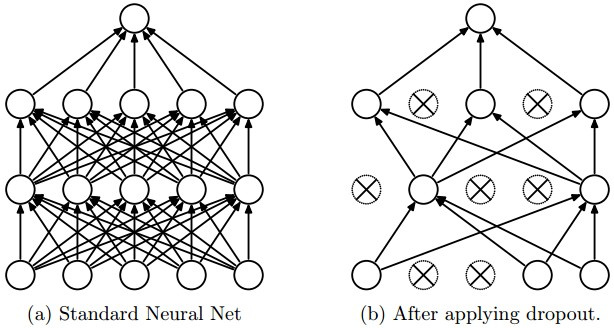


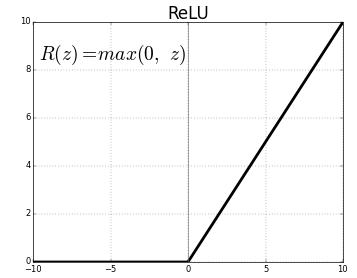


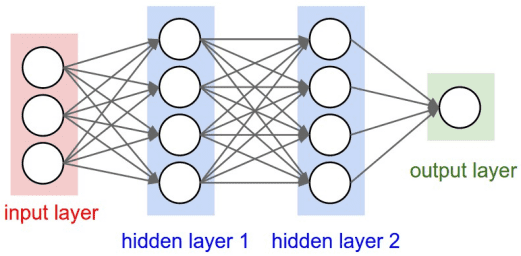

In [15]:
model = BERT(model)
model = model.to(device)
optimizer = AdamW(model.parameters(), lr = 1e-3)

class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights) 

epochs = 1

# Fine-tuning, тонкая настройка

In [16]:
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  # здесь будем сохранять предсказания модели
  total_preds=[]

  for step,batch in enumerate(train_dataloader):
    
    # обновление каждые 50 батчей
    if step % 50 == 0 and not step == 0:
      print('  Батч # {:>5,}  из  {:>5,}.'.format(step, len(train_dataloader)))
    # отправляем данные на устройство
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # обнулить расчеты 
    model.zero_grad()        
    # предсказание
    preds = model(sent_id, mask)
    # потери (реальные и предсказанные значения)
    loss = cross_entropy(preds, labels)
    # суммируем потери
    total_loss = total_loss + loss.item()
    loss.backward()
    # обрезаем градиент;
    # в элементах градиента могут накапливаться большие значения, что будет приводить к сильным изменениям весов;
    # взрывающийся градиент (exploding gradient).
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    # перенос предсказаний на CPU
    preds = preds.detach().cpu().numpy()
    total_preds.append(preds)

  # потери за эпоху
  avg_loss = total_loss / len(train_dataloader)
  # предсказания
  total_preds  = np.concatenate(total_preds, axis=0)

  # потери, предсказания
  return avg_loss, total_preds

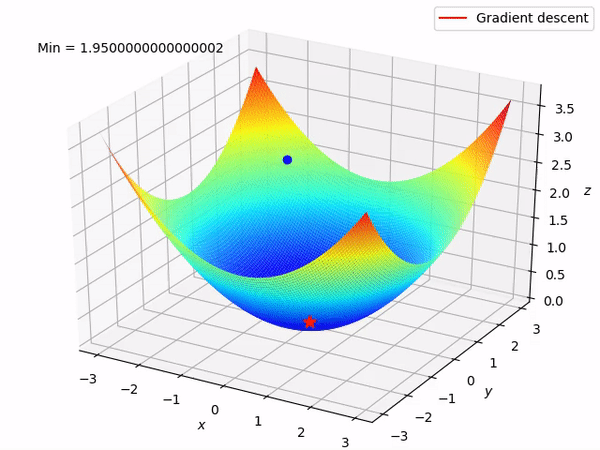

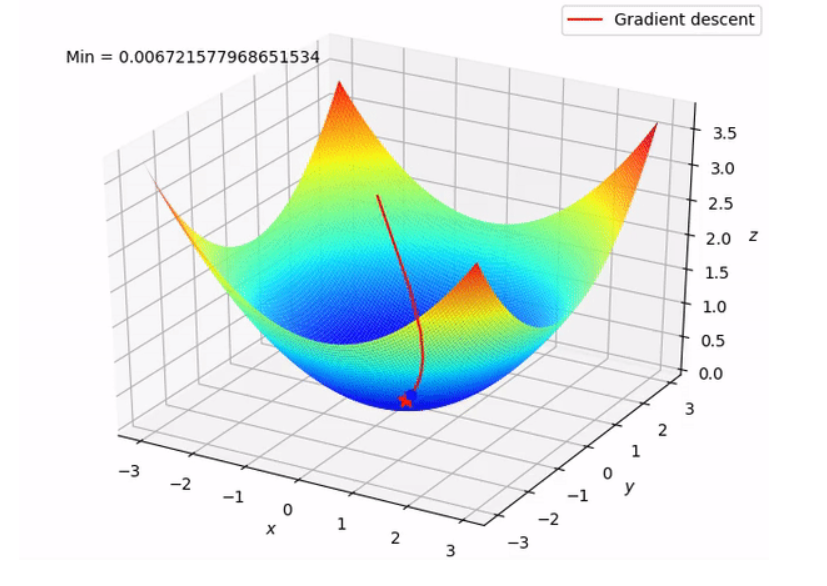

In [17]:
def evaluate():
  
  print("\nПроверка...")
  
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []

  for step,batch in enumerate(val_dataloader):
          
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch

    with torch.no_grad():
      
      # предсказания
      preds = model(sent_id, mask)
      # расчет потерь на проверочной выборке
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Обучение

In [18]:
# потери = бесконечное значение
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
         
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
    # сохраняем лучшую модель
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nПотери на обучающей выборке: {train_loss:.3f}')
    print(f'Потери на проверочной выборке: {valid_loss:.3f}')

  Батч #    50  из    316.
  Батч #   100  из    316.
  Батч #   150  из    316.
  Батч #   200  из    316.
  Батч #   250  из    316.
  Батч #   300  из    316.

Проверка...

Потери на обучающей выборке: 0.516
Потери на проверочной выборке: 0.428


# Сохраненные веса модели можно будет загрузить позднее

In [22]:
path = 'weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Тестируем

In [24]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

predictions = np.argmax(preds, axis = 1)
print(classification_report(test_y, predictions)) 
# Support - сколько раз класс появляется в датасете

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1438
           1       0.69      0.76      0.72       724

    accuracy                           0.80      2162
   macro avg       0.78      0.79      0.79      2162
weighted avg       0.81      0.80      0.81      2162



In [26]:
# Матрица ошибок
pd.crosstab(test_y, predictions)

col_0,0,1
row_0,,
0,1187,251
1,171,553


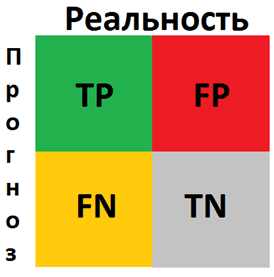

**Полезное и увлекательное чтение (и не только чтение):**
1. Все о Трансформерах: https://huggingface.co/transformers/
2. Все о трансферном обучении: https://vimeo.com/359399507 
3. Speech and Language Processing (3rd ed. draft), Dan Jurafsky and James H. Martin: https://web.stanford.edu/~jurafsky/slp3/
4. Наш любимый Стенфордский курс по NLP: https://www.youtube.com/playlist?list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z
5. DeepLearning: http://d2l.ai/index.html